# Inner Core Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the inner core of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.
We start by assuming the distribution of lightning in the inner core is Gaussian.

*We look at each basin separately. Below are the basin codes:
* ATL - Atlantic Ocean basin
* CPAC - 
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

## Code
Let's start by importing necessary libraries and files. The inner core dataset is created in the `data_cleaning_combined_data.ipynb` notebook (!!!!!!!!!need to rename this notebook lol)

In [26]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation

In [41]:
# import data from csv file
innercore_data = pl.read_csv("innercore_timebin_joined.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)

innercore_data.head()

time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,minute_right,24_hour_knots_diff,24_hour_pressure_diff,TC_Category,Intensification_Category,log_lightning_count
datetime[μs],str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,i64,f64,f64,str,str,f64
2010-06-21 07:00:00,"""ATL_10_1""",1,2010,6,21,7,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.693147
2010-06-21 07:30:00,"""ATL_10_1""",0,2010,6,21,7,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0
2010-06-21 08:00:00,"""ATL_10_1""",0,2010,6,21,8,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0
2010-06-21 08:30:00,"""ATL_10_1""",0,2010,6,21,8,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0
2010-06-21 09:00:00,"""ATL_10_1""",0,2010,6,21,9,0,14.0,-67.6,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0


In [3]:
# create dataframe of storm names for use later
storm_names = innercore_data[["storm_code", "storm_name"]].unique()
storm_names.head()

storm_code,storm_name
str,str
"""WPAC_15_13""","""Soudelor"""
"""WPAC_13_23""","""Danas"""
"""IO_20_1""","""Amphan"""
"""ATL_19_2""","""Barry"""
"""WPAC_15_21""","""Dujuan"""


In [34]:
# IQR threshold function
def detect_bursts_iqr(group):
    Q1 = group['log_lightning_count'].quantile(0.25)
    Q3 = group['log_lightning_count'].quantile(0.75)
    IQR = Q3 - Q1

    # Set burst threshold for each cyclone individually
    threshold1 = Q3 + 1 * IQR
    threshold2 = Q3 + 1.5* IQR

    # Mark bursts specific to the cyclone
    group['burst_iqr_1'] = group['log_lightning_count'] > threshold1
    group['burst_iqr_2'] = group['log_lightning_count'] > threshold2
    group['iqr_1'] = threshold1
    group['iqr_2'] = threshold2
    return group

In [35]:
# MAD threshold function
def detect_bursts_mad(group):
    median_log = group['log_lightning_count'].median()
    mad_log = median_abs_deviation(group['log_lightning_count'])

    # Set burst threshold based on MAD for each cyclone
    threshold1 = median_log + 4 * mad_log
    threshold2 = median_log + 5 * mad_log

    # Mark bursts specific to the cyclone
    group['burst_mad_1'] = group['log_lightning_count'] > threshold1
    group['burst_mad_2'] = group['log_lightning_count'] > threshold2
    group['mad_1'] = threshold1
    group['mad_2'] = threshold2
    return group

In [36]:
#Log normal threshold function
def detect_bursts_lognormal(group):
     # Calculate the mean and standard deviation of the log-transformed lightning count
    mean_log = group['log_lightning_count'].mean()
    std_log = group['log_lightning_count'].std()

    # Set burst thresholds based on log-normal distribution (mean + 2σ and mean + 3σ)
    threshold1 = mean_log + 2 * std_log
    threshold2 = mean_log + 3 * std_log

    # Mark bursts specific to the cyclone
    group['burst_lognormal_1'] = group['log_lightning_count'] > threshold1
    group['burst_lognormal_2'] = group['log_lightning_count'] > threshold2
    group['lognormal_2sigma'] = threshold1
    group['lognormal_3sigma'] = threshold2
    return group

In [51]:
# apply functions to data
pd_data = innercore_data.to_pandas()
processed = pd_data.groupby(["storm_code", "Intensification_Category"]).apply(detect_bursts_iqr)
processed.reset_index(drop=True, inplace=True)
processed = processed.groupby(["storm_code","Intensification_Category"]).apply(detect_bursts_mad)
processed.reset_index(drop=True, inplace=True)
processed = processed.groupby(["storm_code","Intensification_Category"]).apply(detect_bursts_lognormal)
processed.reset_index(drop=True, inplace=True)
agg_result = processed.groupby(["storm_code", "Intensification_Category"]).agg(
    mad1_bursts=('burst_mad_1', 'sum'),
    mad2_bursts=('burst_mad_2', 'sum'),
    mad1_threshold=('mad_1', 'max'),
    mad2_threshold=('mad_2', 'max'),
    iqr1_bursts=('burst_iqr_1', 'sum'),
    iqr2_bursts=('burst_iqr_2', 'sum'),
    iqr1_threshold=('iqr_1', 'max'),
    iqr2_threshold=('iqr_2', 'max'),
    logn1_bursts=('burst_lognormal_1', 'sum'),
    logn2_bursts=('burst_lognormal_2', 'sum'),
    logn1_threshold=('lognormal_2sigma', 'max'),
    logn2_threshold=('lognormal_3sigma', 'max'),
    total_bins=('storm_code', 'count')
)
agg_result.reset_index(drop=False, inplace=True)
agg_result.head(10)

,storm_code,Intensification_Category,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins
0,ATL_10_1,Intensifying,47,47,0.0,0.0,25,21,1.386294,1.732868,13,3,2.300315,3.212423,168
1,ATL_10_1,Neutral,23,23,0.0,0.0,23,23,0.000000,0.000000,16,6,1.063912,1.526130,220
2,ATL_10_1,Unidentified,5,5,0.0,0.0,5,5,0.000000,0.000000,5,2,0.632860,0.904742,48
3,ATL_10_1,Weakening,11,11,0.0,0.0,0,0,4.578312,5.722889,1,0,4.103690,5.574447,24
4,ATL_10_11,Intensifying,32,32,0.0,0.0,20,18,1.039721,1.299651,6,5,2.632009,3.707869,126
5,ATL_10_11,Neutral,44,44,0.0,0.0,44,44,0.000000,0.000000,17,11,1.736404,2.477530,289
6,ATL_10_11,Rapidly Intensifying,4,4,0.0,0.0,4,4,0.000000,0.000000,4,2,0.522640,0.754097,60
7,ATL_10_11,Unidentified,4,4,0.0,0.0,4,4,0.000000,0.000000,4,2,0.647647,0.931145,48
8,ATL_10_11,Weakening,6,6,0.0,0.0,6,6,0.000000,0.000000,6,2,0.530860,0.773261,138
9,ATL_10_12,Intensifying,2,2,0.0,0.0,0,0,1.039721,1.299651,0,0,0.946928,1.304868,6


<Figure size 720x360 with 0 Axes>

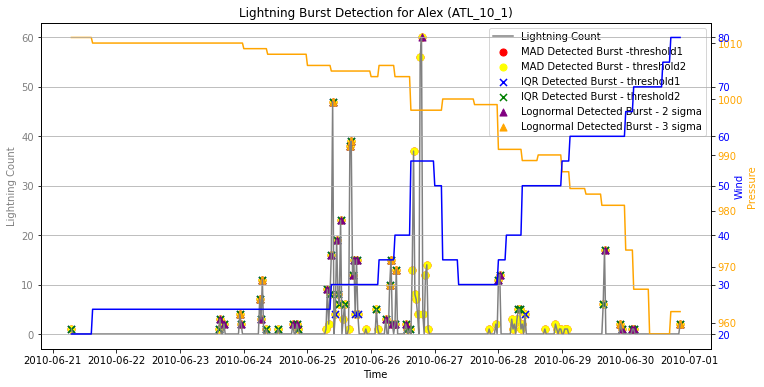

,storm_code,mad1_bursts,mad2_bursts,mad1_threshold,mad2_threshold,iqr1_bursts,iqr2_bursts,iqr1_threshold,iqr2_threshold,logn1_bursts,logn2_bursts,logn1_threshold,logn2_threshold,total_bins
0,ATL_10_1,86,86,0.0,0.0,53,49,4.578312,5.722889,35,11,4.10369,5.574447,460


In [47]:
# Select a specific cyclone to visualize
cyclone_id = 'ATL_10_1'
cyclone_name = storm_names.filter(pl.col("storm_code") == cyclone_id)["storm_name"].item()
df_cyclone = processed[processed['storm_code'] == cyclone_id]

plt.figure(figsize=(10, 5))

# Create first y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_cyclone['time_bin'], df_cyclone['lightning_count'], label='Lightning Count', color='gray')
ax1.set_xlabel("Time")
ax1.set_ylabel("Lightning Count", color="gray")
ax1.tick_params(axis='y', labelcolor="gray")

# Create second y-axis for pressure
ax2 = ax1.twinx()
ax2.plot(df_cyclone['time_bin'], df_cyclone['pressure'], label='Pressure', color='orange')
ax2.set_ylabel("Pressure", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

# Create third y-axis for wind knot
ax2 = ax1.twinx()
ax2.plot(df_cyclone['time_bin'], df_cyclone['knots'], label='Wind', color='blue')
ax2.set_ylabel("Wind", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")


# Mark bursts detected by MAD
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_1']],
            color='red', label='MAD Detected Burst -threshold1', s=50, marker='o')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_mad_2']],
            color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o')

# Mark bursts detected by IQR
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_1']],
            color='blue', label='IQR Detected Burst - threshold1', s=50, marker='x')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_iqr_2']],
            color='green', label='IQR Detected Burst - threshold2', s=50, marker='x')

# Mark bursts detected by lognormal threshold
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_1']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_1']],
            color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^')
ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_lognormal_2']],
            df_cyclone['lightning_count'][df_cyclone['burst_lognormal_2']],
            color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^')

plt.xlabel('Time')
plt.title(f'Lightning Burst Detection for {cyclone_name} ({cyclone_id})')
ax1.legend()
plt.xticks(visible=False)
plt.grid()
plt.show()

# print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]